# Example: Evolutive equilibrium calculations

This notebook will demonstrate the core use-case for FreeGSNKE - the dynamical (time-dependent) evolution of GS equilibria. Here we will:
- build the tokamak machine.
- instatiate a Grad-Shafranov equilibrium (to be used as an initial condition for the evolutive solver).
- evolve the active coil currents by solving the circuit equations (and therefore calcualte the evolution of the initial equilibrium over time).

Refer to the paper by [Amorisco et al. (2024)](https://pubs.aip.org/aip/pop/article/31/4/042517/3286904/FreeGSNKE-A-Python-based-dynamic-free-boundary) for more details. 


## Import packages

In [1]:
import numpy as np
import freegsfast
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output
import time
import os
import pickle

## Build the machine

In [2]:
# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U-like_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U-like_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U-like_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U-like_limiter.pickle"

In [3]:
# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

No probe configuration is provided


# Diverted plasma example

## Instantiate an equilibrium

In [4]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,                # Number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # Number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

## Instatiate a profile object

In [5]:
from freegsnke.jtor_update import ConstrainPaxisIp

profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=8.1e3,  # profile object
    Ip=6.2e5,     # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

## Set coil currents
Here we set coil currents that create a diverted plasma (as seen in prior notebooks). 

In [6]:
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)

for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

## Instatiate the solver object

In [7]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

## Call forward solver to find equilibrium 

In [8]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-8,
                     verbose=0)

## Plot the initial equilibrium 

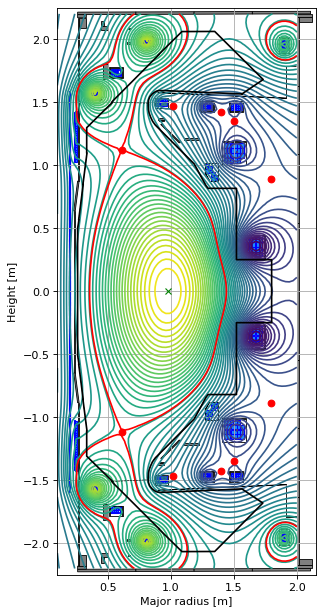

In [9]:
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

## Time evolution

We are now ready to solve the forward time-evolutive problem.

### Initialise nonlinear (evolutive) solver
To start, we need to initialise the evolutive solver object, `freegsnke.nonlinear_solve.nl_solver`. This uses an equilibrium to inform the solver of the machine and domain properties.

The time-evolutive solver also requires:
- `profiles`: defined above.
- `full_timestep`: the time step by which time is advanced at every call of the stepper.
- `plasma_resistivity`: resistivity of the plasma, which is assumed to be constant during the time evolution.

The solver can be used on different equilibria and/or profiles, but these need to have the same machine, domain and limiter as the one used at the time of the solver instantiation. For different machines, a new time-evolutive solver should be created.

The input equilibrium and profile functions are also used as the expansion point around which the dynamics are linearised.

In [10]:
from freegsnke import machine_config

At least one of the self inductance and resistance data files does not exist. Calculating them now.


In [11]:
from freegsnke import nonlinear_solve

stepping = nonlinear_solve.nl_solver(
    eq=eq, profiles=profiles, 
    full_timestep=5e-4, 
    plasma_resistivity=1e-6,
    min_dIy_dI=.1
)

Input max_mode_frequency corresponds to  16  independent vessel normal modes in addition to the  12  active coils.
I'm building the linearization wrt the currents. This may take a minute or two.
I'm building the linearization wrt the profile parameters.
Mode removal is ON: the input min_dIy_dI corresponds to keeping 24 out of the original 28 metal modes.
This equilibrium has a linear growth rate of 1/ 0.007903311156065296 s
The solver's timestep was set at 0.0005  as explicitly requested. Please compare this with the linear growth rate and, if necessary, reset.


### Set active coil voltages

In this example, we will evolve a plasma in absence of any control policy or current drive.

The following calculates active voltages to apply to the poloidal field coils using $V = RI$, in order to maintain the current values that defined the initial equilibrium.

In most FreeGSNKE use cases, these active voltages will be determined by a control policy.

In [12]:
U_active = (stepping.vessel_currents_vec*stepping.evol_metal_curr.R)[:stepping.evol_metal_curr.n_active_coils] 

To start, the solver is prepared by setting the initial conditions.

In [13]:
stepping.initialize_from_ICs(eq, profiles)

### Set time steps and storage lists
Now we set the total number of time steps we want to simulate and initialise some variables for logging the evolution.

In [14]:
# Number of time steps to simulate
max_count = 45

# Initialising some variables for iteration and logging
counter = 0
t = 0

history_times = [t]
history_currents = [stepping.currents_vec]
history_equilibria = [deepcopy(stepping.eq1)]
separatrix = stepping.eq1.separatrix(ntheta=100)
history_width = [np.amax(separatrix[:,0]) - np.amin(separatrix[:,0])]
history_o_points = [stepping.eq1.opt[0]]
history_elongation = [(np.amax(separatrix[:,1]) - np.amin(separatrix[:,1]))/history_width[0]]

### Call the solver (linear)
Finally, we sequentially call the time-evolutive solver with `stepping.nlstepper()` until we reach the pre-set end time.

The following demonstrates a solely linear evolution of the plasma by setting `linear_only=True`.

In [15]:
# loop over time steps
while counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    display(f'current time t = {t:.2e}')

    # carry out the time step
    stepping.nlstepper(
        active_voltage_vec=U_active, 
        linear_only=True,
        verbose=0
    )

    # store information on the time step
    t += stepping.dt_step
    history_times.append(t)
    counter += 1

    # store time-advanced equilibrium, currents, and profiles (+ other quantites of interest)
    history_currents.append(stepping.currents_vec)
    history_equilibria.append(deepcopy(stepping.eq1))
    separatrix = stepping.eq1.separatrix(ntheta=100)
    history_width.append(np.amax(separatrix[:,0]) - np.amin(separatrix[:,0]))
    history_o_points = np.append(history_o_points, [stepping.eq1.opt[0]], axis=0)
    history_elongation.append((np.amax(separatrix[:,1]) - np.amin(separatrix[:,1]))/history_width[-1])

# transform lists to arrays
history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)

'Step: 44/44'

'current time t = 2.20e-02'

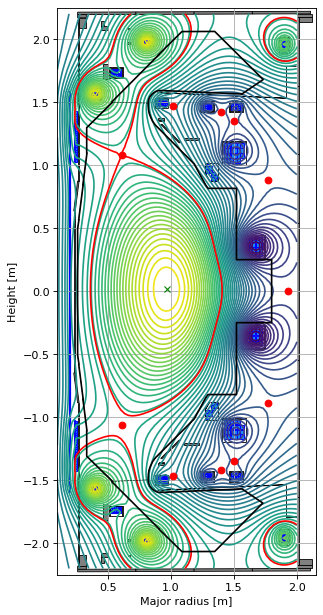

In [16]:
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)

ax1.grid(True, which='both')
history_equilibria[-1].plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)

plt.tight_layout()

### Call the solver (nonlinear)

Now we evolve the same plasma according to the full nonlinear dynamics for the same time interval. This is done by using `linear_only=False` in the call to the stepper.

We need to re-initialise from the initial conditions and reset the counter, but otherwise the method is identical to the one above.

Note that the full nonlinear evolutive solve is a lot more computationally expensive than solving the linear evolutive problem. As such, the following cell may take several minutes to execute, depending on your hardware.

In [17]:
# reset the solver object by resetting the initial conditions
stepping.initialize_from_ICs(eq, profiles)

# initialising some variables for iteration and logging
counter = 0
t = 0

history_times_nl = [t]
history_currents_nl = [stepping.currents_vec]
history_equilibria_nl = [deepcopy(stepping.eq1)]
separatrix = stepping.eq1.separatrix(ntheta=100)
history_width_nl = [np.amax(separatrix[:,0]) - np.amin(separatrix[:,0])]
history_o_points_nl = [stepping.eq1.opt[0]]
history_elongation_nl = [(np.amax(separatrix[:,1]) - np.amin(separatrix[:,1]))/history_width[0]]

# loop over the time steps
while counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    display(f'current time t = {t:.2e}')
    
    # carry out the time step
    stepping.nlstepper(
        active_voltage_vec=U_active, 
        linear_only=False,
        verbose=0
    )

    # store information on the time step
    t += stepping.dt_step
    history_times_nl.append(t)
    counter += 1
    
    # store time-advanced equilibrium, currents, and profiles (+ other quantites of interest)
    history_currents_nl.append(stepping.currents_vec)
    history_equilibria_nl.append(deepcopy(stepping.eq1))
    separatrix = stepping.eq1.separatrix(ntheta=100)
    history_width_nl.append(np.amax(separatrix[:,0]) - np.amin(separatrix[:,0]))
    history_o_points_nl = np.append(history_o_points_nl, [stepping.eq1.opt[0]], axis=0)
    history_elongation_nl.append((np.amax(separatrix[:,1]) - np.amin(separatrix[:,1]))/history_width_nl[-1])

# transform lists to arrays
history_currents_nl = np.array(history_currents_nl)
history_times_nl = np.array(history_times_nl)
history_o_points_nl = np.array(history_o_points_nl)

'Step: 44/44'

'current time t = 2.20e-02'

### Plot some time-evolving quantities
The following plots the evolution of a number of tracked values and compares the linear/nonlinear evoltuions against one another. 

Text(0, 0.5, 'Plasma elongation')

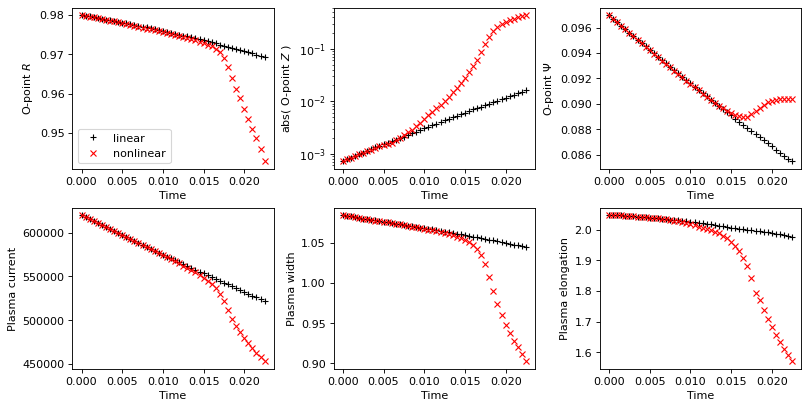

In [18]:
# Plot evolution of tracked values and compare between linear and non-linear evolution
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0],'k+', label='linear')
axs_flat[0].plot(history_times_nl, history_o_points_nl[:, 0],'rx', label='nonlinear')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')
axs_flat[0].legend()

axs_flat[1].plot(history_times, abs(history_o_points[:, 1]),'k+')
axs_flat[1].plot(history_times_nl, abs(history_o_points_nl[:, 1]),'rx')
axs_flat[1].set_yscale('log')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('abs( O-point $Z$ )')

axs_flat[2].plot(history_times, history_o_points[:, 2],'k+')
axs_flat[2].plot(history_times_nl, history_o_points_nl[:, 2],'rx')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times, history_currents[:,-1]*stepping.plasma_norm_factor,'k+')
axs_flat[3].plot(history_times_nl, history_currents_nl[:,-1]*stepping.plasma_norm_factor,'rx')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_width,'k+')
axs_flat[4].plot(history_times_nl, history_width_nl,'rx')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times, history_elongation,'k+')
axs_flat[5].plot(history_times_nl, history_elongation_nl,'rx')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

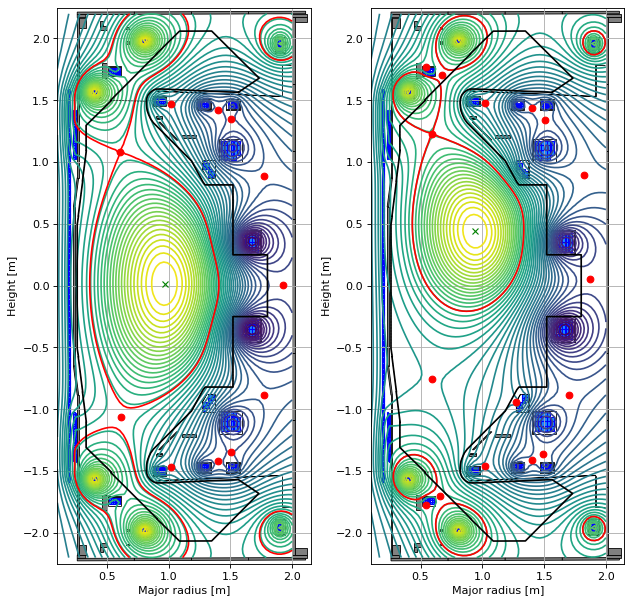

In [19]:
# plot the equilibria at the final time step
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=80)

ax1.grid(True, which='both')
history_equilibria[-1].plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)

ax2.grid(True, which='both')
history_equilibria_nl[-1].plot(axis=ax2, show=False)
eq.tokamak.plot(axis=ax2, show=False)
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
plt.tight_layout()

# Limited plasma example

Finally, we examine a limiter configuration (there is no fundamental difference from the process described above).

First we re-instantiate the equilibrium object.

In [20]:
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,
    Zmin=-2.2, Zmax=2.2,
    nx=65, 
    ny=129
)  

We load a set of coil currents that will give us a limiter plasma in our current tokamak.

In [21]:
import json
with open('limiter_currents.json', 'r') as f:
    current_values = json.load(f)

for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

Now we set the profiles.

In [22]:
profiles = ConstrainPaxisIp(
    eq=eq,
    limiter=tokamak.limiter,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

The final part of the setup is to do a forward solve and visualise the limiter equilibrium.
The red dashed line is the flux surface through the first X-point, however, the actual last closed flux surface in limiter equilibria is displayed as a full black line. 

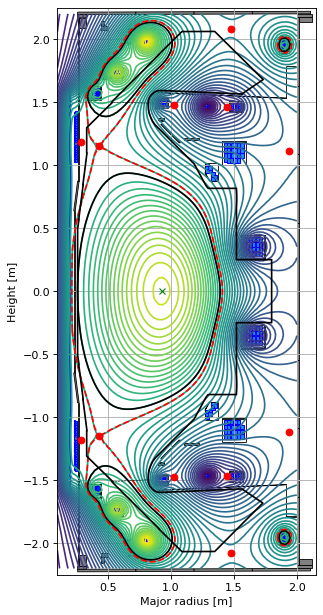

In [23]:
GSStaticSolver.solve(eq, profiles, target_relative_tolerance=1e-8)

fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

Finally, we can do the nonlinear evolutive solve as before. First, we re-initialize the solver, which calculates the linearization of the dynamics relevant to this new equilibrium.

In [24]:
from freegsnke import nonlinear_solve

stepping = nonlinear_solve.nl_solver(
    eq=eq, profiles=profiles, 
    full_timestep=.5e-3, 
    plasma_resistivity=1e-6,    
)

Input max_mode_frequency corresponds to  16  independent vessel normal modes in addition to the  12  active coils.
I'm building the linearization wrt the currents. This may take a minute or two.
I'm building the linearization wrt the profile parameters.
Mode removal is ON: the input min_dIy_dI corresponds to keeping 24 out of the original 28 metal modes.
This equilibrium has a linear growth rate of 1/ 0.2720837656194395 s
The solver's timestep was set at 0.0005  as explicitly requested. Please compare this with the linear growth rate and, if necessary, reset.


In [25]:
# recalculate the active voltages using the new currents
U_active = (stepping.vessel_currents_vec*stepping.evol_metal_curr.R)[:stepping.evol_metal_curr.n_active_coils] 

# number of time steps to simulate
max_count = 45

# reset the solver object by resetting the initial conditions
stepping.initialize_from_ICs(eq, profiles)

# initialising some variables for iteration and logging
counter = 0
t = 0

history_times_nl = [t]
history_currents_nl = [stepping.currents_vec]
history_equilibria_nl = [deepcopy(stepping.eq1)]
separatrix = stepping.eq1.separatrix(ntheta=100)
history_width_nl = [np.amax(separatrix[:,0]) - np.amin(separatrix[:,0])]
history_o_points_nl = [stepping.eq1.opt[0]]
history_elongation_nl = [(np.amax(separatrix[:,1]) - np.amin(separatrix[:,1]))/history_width[0]]

# Simulate the forward evolution
while counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    display(f'current time t = {t:.2e}')
    
    # carry out the time step
    stepping.nlstepper(
        active_voltage_vec=U_active, 
        linear_only=False,
        target_relative_tol_currents=0.01,
        target_relative_tol_GS=0.01,

    )

    # store information on the time step
    t += stepping.dt_step
    history_times_nl.append(t)
    counter += 1
    
    # store time-advanced equilibrium, currents, and profiles (+ other quantites of interest)
    history_currents_nl.append(stepping.currents_vec)
    history_equilibria_nl.append(deepcopy(stepping.eq1))
    separatrix = stepping.eq1.separatrix(ntheta=100)
    history_width_nl.append(np.amax(separatrix[:,0]) - np.amin(separatrix[:,0]))
    history_o_points_nl = np.append(history_o_points_nl, [stepping.eq1.opt[0]], axis=0)
    history_elongation_nl.append((np.amax(separatrix[:,1]) - np.amin(separatrix[:,1]))/history_width_nl[-1])

# transform lists to arrays
history_currents_nl = np.array(history_currents_nl)
history_times_nl = np.array(history_times_nl)
history_o_points_nl = np.array(history_o_points_nl)

'Step: 44/44'

'current time t = 2.20e-02'

Text(0, 0.5, 'Plasma elongation')

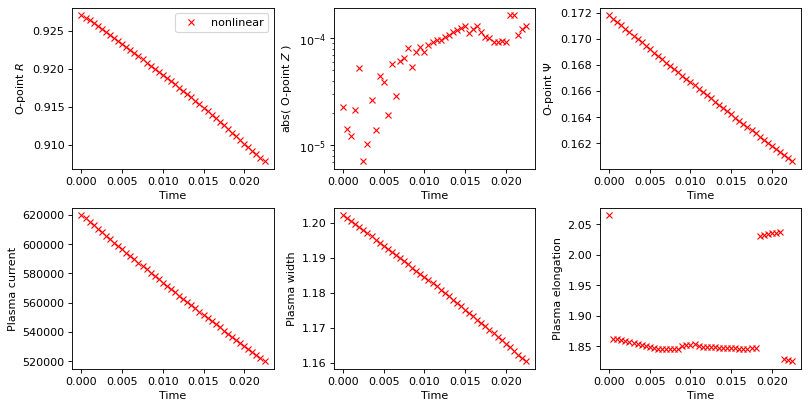

In [26]:
# Plot evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times_nl, history_o_points_nl[:, 0],'rx', label='nonlinear')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')
axs_flat[0].legend()

axs_flat[1].plot(history_times_nl, abs(history_o_points_nl[:, 1]),'rx')
axs_flat[1].set_yscale('log')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('abs( O-point $Z$ )')

axs_flat[2].plot(history_times_nl, history_o_points_nl[:, 2],'rx')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times_nl, history_currents_nl[:,-1]*stepping.plasma_norm_factor,'rx')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times_nl, history_width_nl,'rx')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times_nl, history_elongation_nl,'rx')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

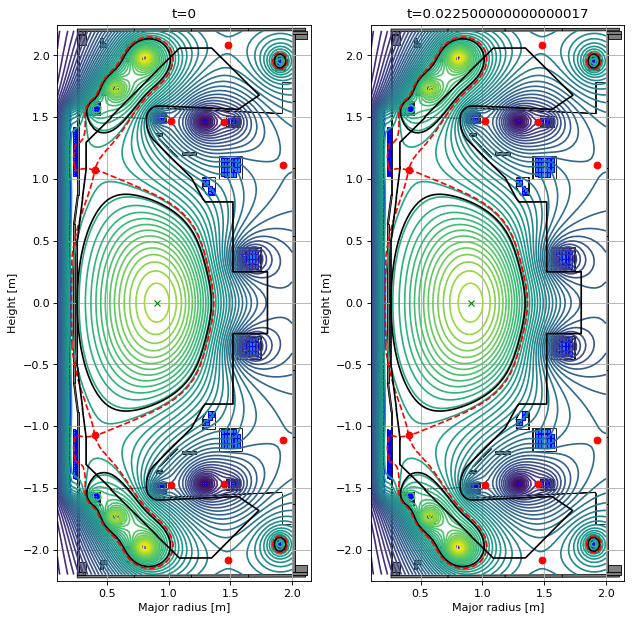

In [27]:
# plot the equilibria at the final time step
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=80)

ax1.grid(True, which='both')
history_equilibria_nl[-1].plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title('t=0')

ax2.grid(True, which='both')
history_equilibria_nl[-1].plot(axis=ax2, show=False)
eq.tokamak.plot(axis=ax2, show=False)
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title('t='+str(t))
plt.tight_layout()